In [ ]:
pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 29.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.5.9-cp310-cp310-linux_x86_64.whl size=2469058 sha256=3bc3bccd6b763c18c070b89138476b611bce73142296879ba847fba6a33612c7
  Stored in directory: /root/.cache/pip/wheels/77/72/2c/993efbb4d69a86bee422bc96e4e2f1ec9af7cc596a08bb86e1
  Created wheel for hdmedians: filename=hdmedians-0.14.2-cp310-cp310-linux_x86_64.whl size=677850 sha256=b7acf9f3e6066357bd646d9ee0f1ad1252f7135e3d3cfd4d761fc16793786dc2
  Stored in directory: /root/.cache/pip/wheels/82/8f/0d/0c61130cfad119482ebb95ae

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas
import numpy
import math
import scipy
import seaborn
import skbio
from scipy import stats
from sklearn import decomposition, linear_model, ensemble, model_selection
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
seaborn.set_style("white")

In [ ]:
class PregnancyMultiomics():
    '''

    Data is taken from .csv files that were created from the raw .Rda file

    Args:
        Folder in which the raw data (from the .Rda file) is split into .csv files.

    Attributes:
        patients (pandas.Series): ID of patient of each sample
        trimesters (pandas.Series): Trimester in which the sample was taken from.
        featureindex (pandas.Series): Indices of the 51 samples during gestation.
        weeks (pandas.Series): Weeks of pregnancy from the beginning
        sample_ids (pandas.Series): IDs of samples taken during gestation
        omics (dict): Dictionary in which keys are the omic measures and values point to the raw data.
    '''
    def __init__(self, folder):
        self.patients = pandas.read_csv(folder + '/' + 'featurepatients.csv', squeeze = True)
        self.trimesters = pandas.read_csv(folder + '/' + 'featuretimes.csv', squeeze = True)
        self.weeks = pandas.read_csv(folder + '/' + 'featureweeks.csv', squeeze = True)
        self.featureindex = pandas.read_csv(folder + '/' + 'featureindex.csv', squeeze = True)

        # generate the sample IDs (for each -omic measure) by joining the patient IDs with trimester using underscore
        self.sample_ids = pandas.Series(map('_'.join, zip(self.patients.astype(str), self.trimesters.astype(str))))

        # store omic data in a dictionary for easy/efficient reference/indexing
        omic_measures = ['CellfreeRNA', 'PlasmaLuminex', 'SerumLuminex', 'Microbiome', 'ImmuneSystem', 'Metabolomics', 'PlasmaSomalogic']
        self.omics = {omic:pandas.read_csv(folder + '/' + '{0}.csv'.format(omic), index_col = 0) for omic in omic_measures}


    def summarize_datasets(self):
        '''Returns a table that describes the dimensions of each omic dataset
        Args:
            None

        Returns:
            summary_df (pandas.DataFrame): a table in which indices are the names of the dataset and
                                                columns detail the number of samples and number of features
        '''
        summary = {}

        # iterate through each omic dataset and get number of samples and features
        for omic in self.omics.keys():
            omic_rows, omic_cols = self.omics[omic].shape
            summary[omic] = [omic_rows, omic_cols]

        # create data frame
        summary_df = pandas.DataFrame.from_dict(summary, orient = 'index')
        summary_df.columns = ['samples','features']
        return summary_df

    def subset_trimester(self, trimester):
        '''Given a valid trimester (1, 2, or 3), return the IDs of samples from that trimester
        Args:
            trimester (int): pregnancy trimester (1, 2, or 3)
        Returns:
            samples (numpy.array): samples from the given trimester
        '''
        # check if inputted trimester is valid
        if trimester not in range(1,4):
            print('ERROR: not a valid trimester, please input a value of 1 through 3')
            return None
        else:
            # subset samples
            return self.sample_ids[self.trimesters == trimester].values

    def permanova(self):
        '''Perform PERMANOVA analysis on the pairwise Euclidean distance matrix for each omic measure by sample and trimester

        Args:
            None

        Returns:
            permanova_df (pandas.DataFrame): table of p-values; first column is between donor comparison and second column is between trimesters
            distance_matrices (pandas.DataFrame): dictionary of pairwise Euclidean distances between samples; keys are omic dataset names and values are distance matrices
        '''
        permanova_pval = {}
        distance_matrices = {}
        for omic in self.omics.keys():
            omic_data = self.omics[omic].copy()
            omic_data = omic_data.loc[self.sample_ids,:]

            # generate a pair-wise distance matrix based on euclidean distances
            # NOTE: the use euclidean distances is for convenience.
            #       Different 'omic' measures often have different preferred methods for calculating distances
            distance_matrix = squareform(pdist(omic_data.values, metric='euclidean'))
            distance_matrix = pandas.DataFrame(distance_matrix)
            distance_matrix.index = omic_data.index
            distance_matrix.columns = omic_data.index

            # get categorical variables (by sample and by trimester)
            samples = distance_matrix.index.str.split('_').str[0]
            trimesters = distance_matrix.index.str.split('_').str[1]

            # perform PERMANOVA analysis
            distance_matrix_skbio = skbio.DistanceMatrix(distance_matrix, ids=distance_matrix.index)
            trimester_permanova = skbio.stats.distance.permanova(distance_matrix_skbio, trimesters, permutations=999)
            donor_permanova = skbio.stats.distance.permanova(distance_matrix_skbio, samples, permutations=999)

            permanova_pval[omic] = {'pval_trimester': trimester_permanova['p-value'], 'pval_donor': donor_permanova['p-value']}
            distance_matrices[omic] = distance_matrix

        # generate p-value table
        permanova_df = pandas.DataFrame.from_dict(permanova_pval, orient = 'index')
        permanova_df.to_csv('permanova.csv')
        return permanova_df, distance_matrices

    def within_between_comparisons(self, distance_matrix_dict = None, comparison = 'donor_comparison', out_png = None):
        '''Create boxplot and stripplot of within group and betwene group comparisons

        Args:
            distance_matrix_dict (dict): dictionary where keys are omic types and values are pairwise distance matrices
            comparison (str): types of comparison to be made (donor_comparison, trimester_comparison)
            out_png (str): filename to which the final plot should be saved to

        Returns:
            None
        '''
        def comparison_type(row, col1, col2):
            '''Helper function to identify comparison type (within group vs between group) based on inputted row and column

            Args:
                row (pandas.Series): row describing the Euclidean distance between two samples
                col1 (str): column name of the first sample for comparison
                col2 (str): column name of the second sample for comparison
            '''
            if row[col1] == row[col2]:
                return 'within'
            else:
                return 'between'

        # if no inputted distance matrix, compute one
        if distance_matrix_dict == None:
            pvals, distance_matrix_dict = self.permanova()

        # initalize plots
        fig, ax = plt.subplots(4, 2, figsize=(12, 15))
        fig.delaxes(ax[3,1])

        # create counter to assign row and column
        counter = 0

        # iterate through different omic measures, plot and count number of sample with a distance of zero
        for omic in distance_matrix_dict.keys():
            subplot_ax = ax[counter//2][counter % 2]
            counter += 1

            # convert to long form for easier comparison and plotting
            dist_tidy = distance_matrix_dict[omic].reset_index().melt(id_vars = 'index')
            dist_tidy = dist_tidy[dist_tidy['index'] != dist_tidy['variable']] # remove same-sample comparisons
            dist_tidy['donor1'] = dist_tidy['index'].str.split('_').str.get(0)
            dist_tidy['trimester1'] = dist_tidy['index'].str.split('_').str.get(1)
            dist_tidy['donor2'] = dist_tidy['variable'].str.split('_').str.get(0)
            dist_tidy['trimester2'] = dist_tidy['variable'].str.split('_').str.get(1)

            # identify number of potential duplicates, defined as samples where the euclidean distance is zero
            num_potential_duplicates = (dist_tidy['value'] == 0).sum()

            # identify comparison type
            dist_tidy['donor_comparison'] = dist_tidy.apply(lambda x: comparison_type(x, 'donor1', 'donor2'), axis = 1)
            dist_tidy['trimester_comparison'] = dist_tidy.apply(lambda x: comparison_type(x, 'trimester1', 'trimester2'), axis = 1)

            # plot
            subplot_ax = seaborn.boxplot(x = comparison, y = 'value', order = ['within', 'between'], data=dist_tidy, ax = subplot_ax, showfliers = False)
            subplot_ax = seaborn.stripplot(x = comparison, y = 'value', order = ['within', 'between'], data=dist_tidy, ax = subplot_ax)
            subplot_ax.set_title('{0} | # of potential duplicate pairs: {1}'.format(omic, num_potential_duplicates))

        if out_png != None:
            plt.savefig(out_png, bbox_inches="tight")
        else:
            plt.show()
        plt.close()

    def pca(self, modality, num_pcs = 25):
        '''Calculate the principal components of the inputted modality's raw data
        Args:
            modality (str): a vaid omic measure (CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic)
            num_pcs (int): number of PC's to return, default = 25
        Returns:
            pc_matrix (numpy.ndarray): a matrix of coordinates in principal component space (num_samples x num_pcs)
            omic_data (pandas.DataFrame): a DataFrame of z-score normalized data for the inputted modality
        '''
        omic_data = self.omics.get(modality, None)

        # check if the inputted modality is valid
        if type(omic_data) == type(None):
            print('ERROR: not a valid -omic type, please input either: CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic')
            return None

        # get samples during gestation
        omic_data = omic_data.loc[self.sample_ids]
        valid_patients = self.patients[self.featureindex.index]

        # calculate first n PC's
        pca = decomposition.PCA(n_components=num_pcs)
        pc_matrix = pca.fit_transform(omic_data)

        return pc_matrix, omic_data


    def plot_pca(self, modality, out_png = None):
        '''Generate PCA plots, one by batch and one by individual donor, using the raw data of the input modality
        Args:
            modality (str): a vaid omic measure (CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic)
            out_png (str): filename to which the final plot should be saved to

        Returns:
            None: generates a figure of PC 1 and PC 2. The left plot is colored by batch and the right plot is colored by individual donor
        '''

        if modality not in self.omics:
            print('ERROR: not a valid -omic type, please input either: CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic')
            return None

        # calculate PCA
        pca_results, omic_data = self.pca(modality)

        # get samples during gestation
        valid_patients = self.patients[self.featureindex.index]

        # transform into DataFrame to allow for easier indexing/search
        pca_df = pandas.DataFrame(pca_results)
        pca_df.index = omic_data.index

        # PLOT: create 2 plots, left plot is by batch, right plot is by individual donors
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))

        # PLOT 1: set colors by trimester
        trimesters = self.trimesters.unique()
        trimester_colors = dict(zip(trimesters, seaborn.color_palette('Set1', len(trimesters))))

        # iterate through trimesters and plot PC's
        for period in trimesters:
            donor_sample_indices = self.trimesters[self.trimesters == period].index
            temp = pca_df.iloc[donor_sample_indices,:]
            ax1.scatter(temp.loc[:,0], temp.loc[:,1], label = 'trimester {0}'.format(period), color = trimester_colors[period])
        seaborn.despine()
        ax1.legend(bbox_to_anchor = [1,1])
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_title('PCA of {0} by trimester'.format(modality))

        # PLOT 2: set colors by donor ID's
        patient_ids = valid_patients.unique()
        donor_colors = dict(zip(patient_ids, seaborn.color_palette('tab20', len(patient_ids))))

        # iterate through donors and plot PC's
        for donor in patient_ids:
            donor_sample_indices = valid_patients[valid_patients == donor].index
            temp = pca_df.iloc[donor_sample_indices,:]
            ax2.scatter(temp.loc[:,0], temp.loc[:,1], label = donor, color = donor_colors[donor])
        seaborn.despine()
        ax2.legend(bbox_to_anchor = [1,1])
        ax2.set_xlabel('PC1')
        ax2.set_title('PCA of {0} by individual donor'.format(modality))

        if out_png != None:
            plt.savefig(out_png, bbox_inches="tight")
        else:
            plt.show()
        plt.close()

        return None

    def elastic_net_regression(self, modality, input_ax = None, out_png = None):
        ''' Build an elastic net model off of a single modality, plotting the prediction results

        Args:
            modality (str): a vaid omic measure (CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic)
            input_ax (matplotlib.axes): matplotlib subplot axes to which the plot should be drawn to
            out_png (str): filename to which the final plot should be saved to

        Returns:
            r_sq (float): R^2 value of the predictions
            pval (float): p-value value of the predictions
            cv_l1_ratios (float): list of the cv_l1_ratios (alpha in R) in the final modes
            cv_alphas (float): list of the cv_alphas (alpha in R) in the final modes
            coeffs (pandas.DataFrame): dataframe of the coefficient for each modality

        '''
        # subset data such that only samples during gestation are considered
        omic_data = self.omics.get(modality, None).copy()

        if type(omic_data) == type(None):
            print('ERROR: not a valid -omic type, please input either: CellfreeRNA, PlasmaLuminex, SerumLuminex, Microbiome, ImmuneSystem, Metabolomics, PlasmaSomalogic')
            return None

        # keep only samples during gestation
        valid_omic_samples = omic_data.loc[self.sample_ids,:]
        valid_weeks = self.weeks.loc[self.featureindex.index]
        valid_patient_indices = self.patients.loc[self.featureindex.index]
        patients = self.patients.unique()

        # standardize by z-score, keeping only features that have a non-zero standard deviation
        valid_omic_samples = valid_omic_samples.loc[:,valid_omic_samples.std() != 0]
        valid_omic_samples = valid_omic_samples.apply(lambda x: scipy.stats.zscore(x))

        # split into training and test sets by leaving all samples from one patient out at a time
        train_test_loo = []
        for patient in patients:
            training_samples = valid_patient_indices[valid_patient_indices != patient].index.values
            test_samples = valid_patient_indices[valid_patient_indices == patient].index.values
            train_test_loo.append((training_samples, test_samples))

        # store model predictions and parameters
        predicted = []
        actual = []
        cv_l1_ratios = []
        cv_alphas = []
        coeffs = []

        # Parameter Search: Elastic Net model with 3-fold cross validation. Consistent with the paper, we leave one subject out
        en_reg_cv = linear_model.ElasticNetCV(l1_ratio = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0], alphas=range(13), cv=5, max_iter = 1000, n_jobs= 8)

        for (train, test) in train_test_loo:
            # run 3-fold CV on training data to estimate optimal parameters
            en_reg_cv.fit(valid_omic_samples.values[train], valid_weeks.values[train])

            # store model parameters
            cv_l1_ratios.append(en_reg_cv.l1_ratio_)
            cv_alphas.append(en_reg_cv.alpha_)
            predicted.extend(en_reg_cv.predict(valid_omic_samples.values[test]))
            actual.extend(valid_weeks.values[test])
            coeffs.append(en_reg_cv.coef_)

        # check if an subplot axis is inputted, if not, create one
        if input_ax == None:
            input_ax = plt.subplot()
            plot = True
        else:
            plot = False

        # plot and calculate R^2
        input_ax = seaborn.regplot(actual, predicted, ax=input_ax)
        r, pval = scipy.stats.pearsonr(actual, predicted)
        input_ax.set_title("{0} | R$^2$ = {1} | -log_10(p-val) = {2}".format(modality, numpy.round(r**2,3), numpy.round(-numpy.log10(pval), 2)))

        # if no inputted subplot axis, plot
        if plot:
            if out_png != None:
                plt.savefig(out_png, bbox_inches="tight")
            else:
                plt.show()
            plt.close()

        # format coefficent table
        coeffs = pandas.DataFrame(coeffs)
        coeffs.columns = valid_omic_samples.columns

        return r**2, pval, cv_l1_ratios, cv_alphas, coeffs

    def elastic_net_r_squares(self, out_png = None):
        '''Plot the predictability of elastic net models for each omic measure as well as return a table of R^2 values
        Args:
            out_png (str): filename to which the final plot should be saved to

        Returns:
            r_sq_table (pandas.DataFrame): table of r-square values index by the name of the omic measure
            top_features (list): list of features that were used in any given elastic net model (both during cross validation and between omics)
        '''
        # store r-square values in a dictionary
        r_sqs = {}

        # initalize plots
        fig, ax = plt.subplots(4, 2, figsize=(12, 15))
        fig.delaxes(ax[3,1])

        # create counter to assign row and column
        counter = 0

        # track important features
        top_features = []

        # get r-squared values for each omic dataset
        for omic in self.omics.keys():
            subplot_ax = ax[counter//2][counter % 2]
            r_sq, p_val, l1_ratio_list, alpha_list, coeffs_df = self.elastic_net_regression(omic, subplot_ax)

            # find features that were used
            features_used = coeffs_df.loc[:,coeffs_df.mean() > 0].columns

            r_sqs[omic] = {'r_squared': r_sq, 'p-value':p_val, 'num_features_used': len(features_used)}
            top_features.extend(features_used)

            counter += 1

        if out_png != None:
            plt.savefig(out_png, bbox_inches="tight")
        else:
            plt.show()
        plt.close()

        # make r-squared table
        r_sq_table = pandas.DataFrame.from_dict(r_sqs, orient = 'index')
        r_sq_table.to_csv('r_sq_table.csv')

        return r_sq_table, top_features

    def cross_omic_elastic_net(self, select_features = None, out_png = None):
        ''' Build an elastic net model using data from all omic measures, with the option of subsetting to specific features

        Args:
            select_features (list/array-like): OPTIONAL, features to subset the entire table by
            out_png (str): filename to which the final plot should be saved to

        Returns:
            r_sq (float): R^2 value of the predictions
            pval (float): p-value value of the predictions
            coeffs (pandas.DataFrame): dataframe of the coefficient for each modality
        '''
        # combine all omic measures
        all_omics = [data.loc[self.sample_ids,:].T for data in self.omics.values()]
        all_omics = pandas.concat(all_omics).T

        # subset features if provided
        if select_features != None:
            all_omics = all_omics.loc[:, select_features]

        # z-score normalize
        all_omics = all_omics.loc[:, all_omics.std() > 0]
        all_omics = all_omics.apply(lambda x: scipy.stats.zscore(x))

        # get data for samples during genstation
        valid_weeks = self.weeks.loc[self.featureindex.index]
        valid_patient_indices = self.patients.loc[self.featureindex.index]
        patients = self.patients.unique()

        # build training and test set by leaving one subject out
        train_test_loo = []
        for patient in patients:
            training_samples = valid_patient_indices[valid_patient_indices != patient].index.values
            test_samples = valid_patient_indices[valid_patient_indices == patient].index.values
            train_test_loo.append((training_samples, test_samples))

        # run 3 fold cross validation to identify optimal parameters
        l1_ratios_cv = []
        alphas_cv = []
        predicted = []
        actual = []
        coeffs = []

        en_cv = linear_model.ElasticNetCV(l1_ratio = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0], alphas=range(13),
                                  cv=5, max_iter = 1000, n_jobs= 8)
        # fit the model to the training set
        for (train_index, test_index) in train_test_loo:
            en_cv.fit(all_omics.iloc[train_index,:], valid_weeks[train_index])
            l1_ratios_cv.append(en_cv.l1_ratio_)
            alphas_cv.append(en_cv.alpha_)
            predicted.extend(en_cv.predict(all_omics.iloc[test_index,:]))
            actual.extend(valid_weeks[test_index])
            coeffs.append(en_cv.coef_)

        # plot prediction and R^2 value
        seaborn.regplot(actual, predicted)
        r, pval = scipy.stats.pearsonr(actual, predicted)
        plt.title('r$^2$ = {0} | -log_10(p-val) = {1}'.format(numpy.round(r**2, 3), numpy.round(-numpy.log10(pval), 2)))
        df = pandas.DataFrame({'p_value': pval})
        df.to_csv('out_csv')


        if out_png != None:
            plt.savefig(out_png, bbox_inches="tight")
        else:
            plt.show()
        plt.close()

        # format coefficent table
        coeffs = pandas.DataFrame(coeffs)
        coeffs.columns = all_omics.columns



        return r**2, pval, coeffs



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-d14f6d52271d>:18: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  self.patients = pandas.read_csv(folder + '/' + 'featurepatients.csv', squeeze = True)
<ipython-input-8-d14f6d52271d>:19: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  self.trimesters = pandas.read_csv(folder + '/' + 'featuretimes.csv', squeeze = True)
<ipython-input-8-d14f6d52271d>:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  self.weeks = pandas.read_csv(folder + '/' + 'featureweeks.csv', squeeze = True)
<ipython-input-8-d14f6d52271d>:21: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s

                 samples  features
CellfreeRNA           68     37101
PlasmaLuminex         68        62
SerumLuminex          68        62
Microbiome            68     18548
ImmuneSystem          68       534
Metabolomics          68      3485
PlasmaSomalogic       68      1300
                 pval_trimester  pval_donor
CellfreeRNA               0.023       0.013
PlasmaLuminex             0.213       0.001
SerumLuminex              0.342       0.001
Microbiome                0.002       0.911
ImmuneSystem              0.005       0.001
Metabolomics              0.016       0.005
PlasmaSomalogic           0.001       0.002


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-01, tolerance: 1.474e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e-01, tolerance: 1.132e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_co

TypeError: ignored

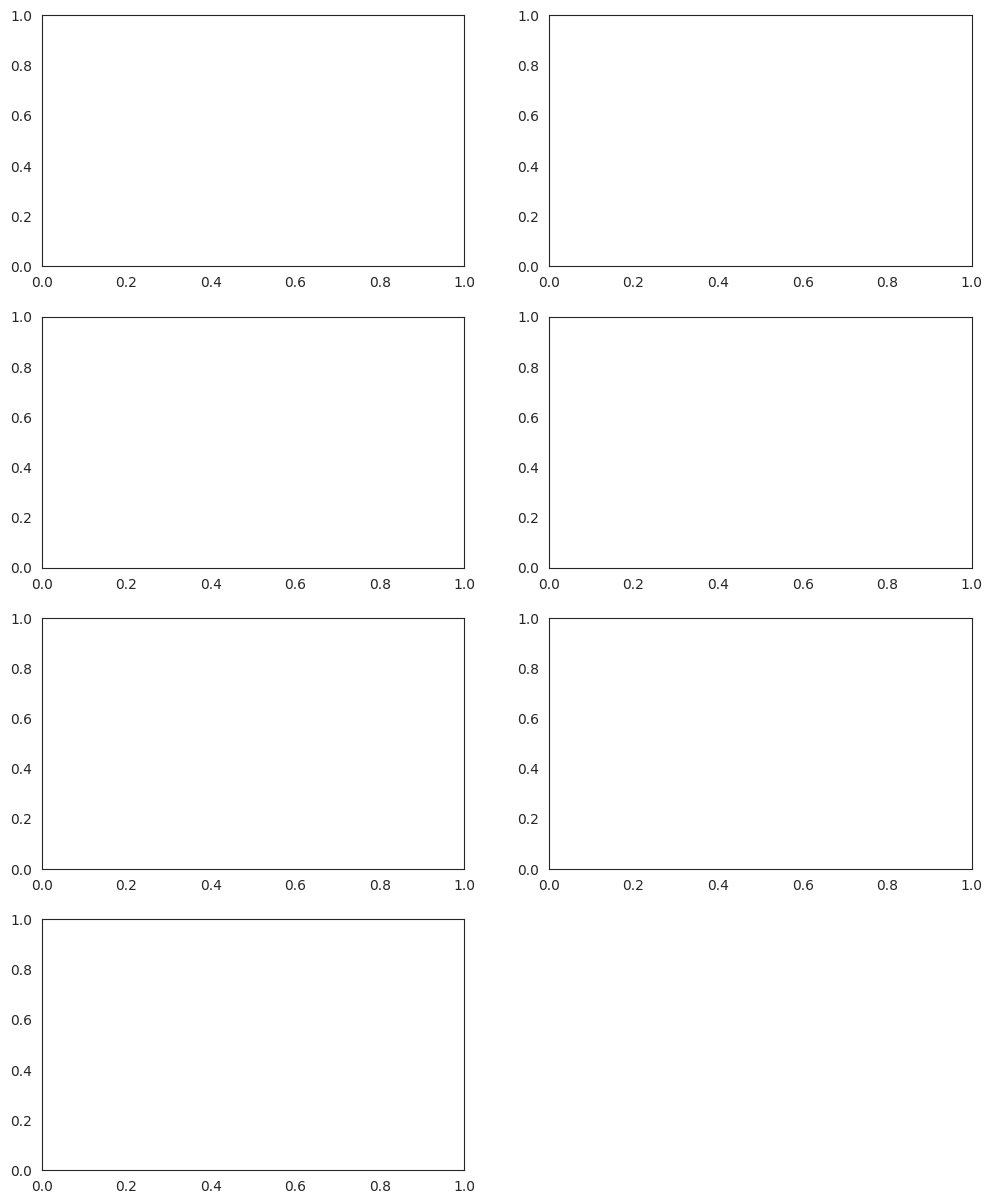

In [ ]:
if __name__ == "__main__":
    # summarize the dataset
    gestation_multiomics=PregnancyMultiomics('/content/drive/MyDrive/Main/Datasets')
    print(gestation_multiomics.summarize_datasets())

    #calculate Euclidean distances and run PERMANOVA
    permanova_df, dist_matrix_dict = gestation_multiomics.permanova()
    print(permanova_df)

    # perform within and between donor comparisons
    gestation_multiomics.within_between_comparisons(distance_matrix_dict = dist_matrix_dict, out_png = '/content/drive/MyDrive/Main')

    # perform PCA analysis, visualize by batch and donor

    for omic in gestation_multiomics.omics.keys():
        gestation_multiomics.plot_pca(omic, out_png = '/content/drive/MyDrive/Main'.format(omic))

    # generate Elastic Net models on each modality
    r2_table, top_omic_features = gestation_multiomics.elastic_net_r_squares(out_png = '/content/drive/MyDrive/Main')
    print(r2_table)

    # take all the used features from the individual omic datasets and use only those features for an EN model
    r2, pval, coeffs = gestation_multiomics.cross_omic_elastic_net(select_features = top_omic_features, out_png = '/Users/arezoupst/Downloads')

    # combine all the data and build an EN model off of that
    #r2_all_omics, pval_all_omics, coeffs_all_omics = gestation_multiomics.cross_omic_elastic_net(out_png = '/Users/arezoupst/Downloads')


